# **Dokumentacja końcowa**
## **Autorzy:** Mateusz Szczęsny, Małgorzata Kubiak
### **Temat projektu:** Nienadzorowana detekcja anomalii na podstawie niepodobieństwa do sąsiadów

## **Pełna treść zadania:**
Nienadzorowana detekcja anomalii na podstawie niepodobieństwa do sąsiadów z możliwością użycia dowolnej miary niepodobieństwa. Porównanie z nienadzorowaną detekcją anomalii za pomocą algorytmów klasyfikacji jednoklasowej dostępnych w środowisku R lub Python.


## **Opis implementacji**
Zaimplementowany algorytm znajduje się w pliku our_knn.py i jest kompatybilny w sposobie użycia z innymi nienadzorowanymi klasyfikatorami binarnymi z biblioteki sklearn.

Jako argumenty przyjmowane są:
*   k - liczba sąsiadów użyta podczas działania
*   threshold_percentile - szacowany procent zbioru danych stanowiący przykłady klasy większościowej
*   distance_funct - funkcja używana do obliczania odległości między przykładami. Domyślnie odległość euklidejska
*   score_funct - funkcja używana do oceny przykładów. Domyślnie średnia z odległości do k najbliższych sąsiadów
*   external_theshold - pozwala na nadpisanie progu użytego do klasyfikacji przykładów na podstawie punktów nadanych przez score_funct

Główne metody to:
*   fit() - używana do uczenia algorytmu
*   predict() - używana do oceny przykładów
*   fit_predict() - woła po sobie fit() i predict()
*   decision_function() - pozwala uzyskać punktacje dla przykładów

Uczenie algorytmu polega na wyznaczeniu odległości między wszystkimi punktami w zbiorze uczącym (przy użyciu distance_funct), a następnie na ich podstawie obliczenie punktacji dla każdego punktu. Przy pomocy threshold_percentile obliczany jest próg punktacji, który zostanie użyty do przypisania klasy dla klasyfikowanego przykładu.

Po wywołaniu funkcji predict obliczana jest odległość klasyfikowanego przykładu do przykładów w zbiorze treningowym. Następnie na podstawie odległości przykłady są oceniane i na podstawie wcześniej ustalonego progu (lub podanego jako argument external_threshold) przykłady są klasyfikowane.

Przy pomocy biblioteki numba, najtrudniejsze obliczeniowo części algorytmu (obliczanie odległości między wszystkimi przykładami) zostały zoptymalizowane, co sprawia, że wydajność algorytmu jest porównywalna z implementacjami algorytmów z biblioteki sklearn.

## Opis testów
Wszystkie testy zostały przeprowadzone przy użyciu 5 krotnej walidacji krzyżowej. Tam gdzie jest to możliwe, zostało zasnaczone odchylenie standardowe dla wyników walidacji.

#Przyspieszenie obliczeń
Aby przyspieszyc obliczenia zmniejszajac wielkosc zbiorow do 2000 nalezy uruchomic ponizszy fragment kodu i ustawic zmienna Speed na True.

In [3]:
Speed = True

## Uzyte bilbioteki

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import test_functions
from our_knn import KNNAnomalyDetector
from sklearn.preprocessing import StandardScaler
import plotting_functions
from sklearn.model_selection import StratifiedKFold
import numba as nb
from sklearn.metrics import precision_recall_curve, auc, f1_score

from pyod.models.knn import KNN
import sklearn.neighbors
import sklearn.ensemble

#%matplotlib ipympl

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Opis i wizualizacje zbiorów danych**

Do testów wybrane zostały 2 zbiory danych znalezione na stronie internetowej Outlier Detection DataSets (ODDS). Są to zbiory "thyroid" i "shuttle".

Zbiór "thyroid" (tarczyca) składa się z 3772 przykładów. Każdy przykład ma 6 ciągłych atrybutów. Klasą traktowaną jako anomalia jest nadczynność tarczycy i stanowi około 2.5% przykładów.

Zbiór "shuttle" po usunięciu niepełnych wpisów oras klasy nr 4 która nie jest używana do zadań związanych z wykrywaniem anomalii zawiera 12345 przykładów. Każdy przykład ma 9 atrybutów. Anomalie stanowią około 7% zbioru danych.

### Wczytywanie i wizualizacja zbioru "thyroid"

In [4]:
# load thyroid dataset
# labels are 0 1 where 1 is anomaly. Feature 1 is an integer. Other features are continuos
thyroid_data = pd.read_csv('thyroid.csv')

if Speed:
  thyroid_data = thyroid_data.iloc[:2000] # shrink dataset for test purposes

thyroid_data_columns = thyroid_data.columns
thyroid_features = thyroid_data[thyroid_data_columns[:6]]
thyroid_labels = thyroid_data[thyroid_data_columns[6]]

# change labels so 1 in no anomalyand -1 is anomaly (sklearn anomaly detecion convention)
thyroid_labels[thyroid_labels == 1] = -1
thyroid_labels[thyroid_labels == 0] = 1

### Korelacja atrybutów w zbiorze danych

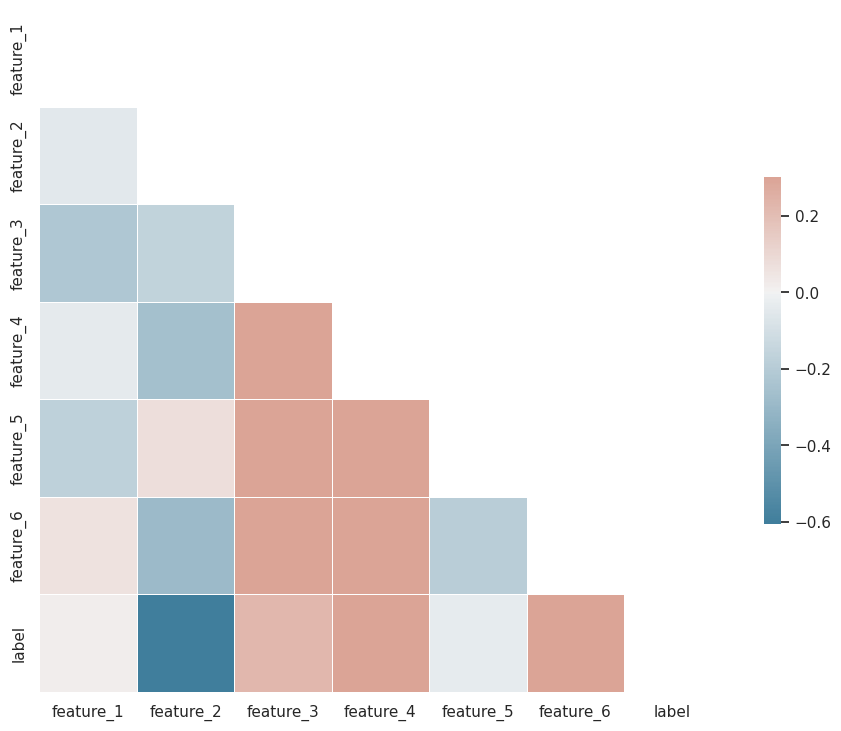

In [ ]:
plotting_functions.plot_corr(thyroid_data)

Widzimy że "feautre_2" ma dość mocną korelacje z klasą. Pozatym Atrybuty mają dość niskie korelacje między sobą.

### Wizualizacja rozkładu atrybutów zbioru "thyroid"

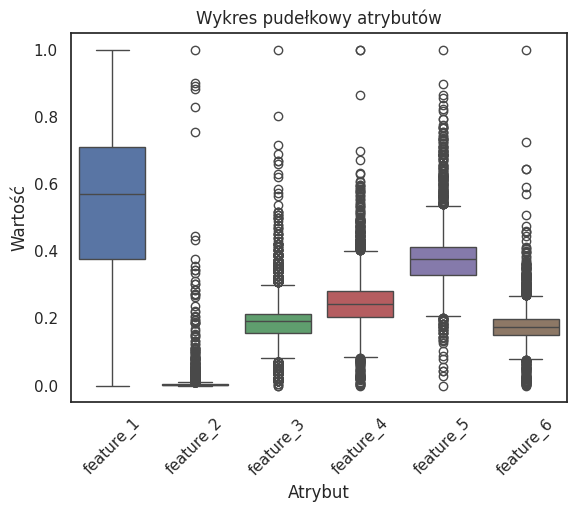

In [ ]:
plotting_functions.plot_feature_dist(thyroid_features)

Na wykresie widzimy że poza atrybutem nr. 1 (feature_1) atrybuty posiadają sporo wartości które można uznać za odstające, czyli wychodzące o ponad 1.5 odległości miedzy pierwszym a trzecim kwartylem od bliższego im brzegu pudełka.

### Wizualizacja relacji 3 głównych komponetnów zbioru "thyroid"

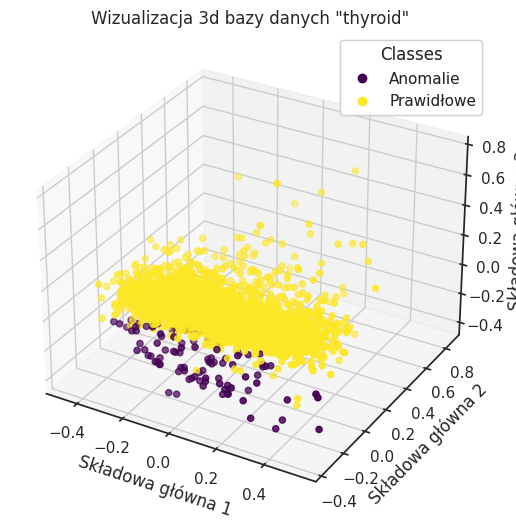

In [ ]:
# 3D PCA thyroid dataset visualisation
plotting_functions.plot_pca_3d(thyroid_features, thyroid_labels, "Wizualizacja 3d bazy danych \"thyroid\"")

Powyższa wizualizacja przedstawia zbiór danych po rozkładzie na 3 główne składowe. Przy takim rozładzie widać że klasa anomalii znajduje się niedaleko ale jednak poza głównym skupiskiem punktów.

## Wczytywanie i wizualizacja zbioru "shuttle"

In [5]:
# shuttle dataset loading. The dataset cointains 9 features and 7 classes. Class '1' makes up 80% of the dataset. For ourlier detection class '4'is discarted and the other classes are combined.
shuttle_colnames=['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'label']
shuttle_data = pd.read_csv('shuttle.tst', sep=' ', header=None, names=shuttle_colnames)

shuttle_data = shuttle_data[shuttle_data['label'] != 4] # remove class '4'

if Speed:
  shuttle_data = shuttle_data.iloc[:2000] # shrink dataset for test purposes

shuttle_features = shuttle_data[shuttle_colnames[:9]]
shuttle_labels = shuttle_data[shuttle_colnames[9]]

shuttle_labels[shuttle_labels == 1] = 1
shuttle_labels[(shuttle_labels == 2) | (shuttle_labels == 3) | (shuttle_labels == 5) | (shuttle_labels == 6) | (shuttle_labels == 7)] = -1


In [6]:
# add standard scaler because of large feature value range differences
shuttle_scaler = StandardScaler()
shuttle_feature_columns = shuttle_features.columns
shuttle_features = pd.DataFrame(shuttle_scaler.fit_transform(shuttle_features), columns=shuttle_feature_columns)

### Wizualizacja korelacji atrybutów zbioru "shuttle"

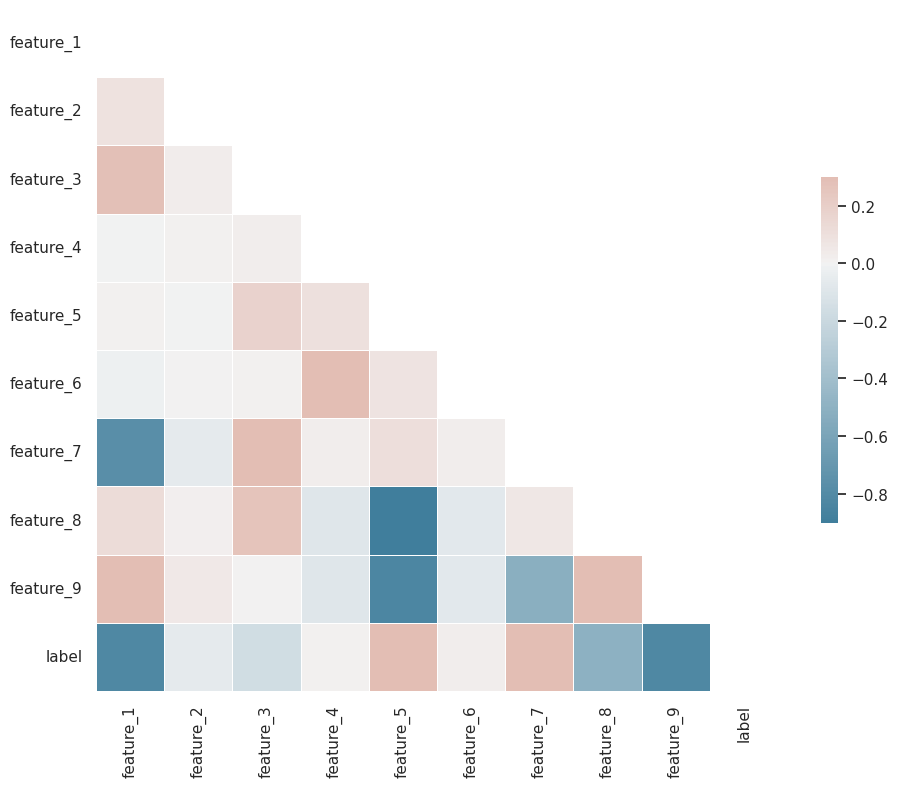

In [ ]:
plotting_functions.plot_corr(shuttle_data)

W zbiorze "shuttle" widzimy ujemną korelacje między feature_1 i fature_9 a klasą przykładu. Widzimy też ujemne korelacje między atrybutami o numerach 1 i 7, 5 i 8 oraz 5 i 9. Reszta korelacji jest dużo mniejsza.

### Wizyalizacja rozkładu wartości atrybutów zbioru "shuttle"

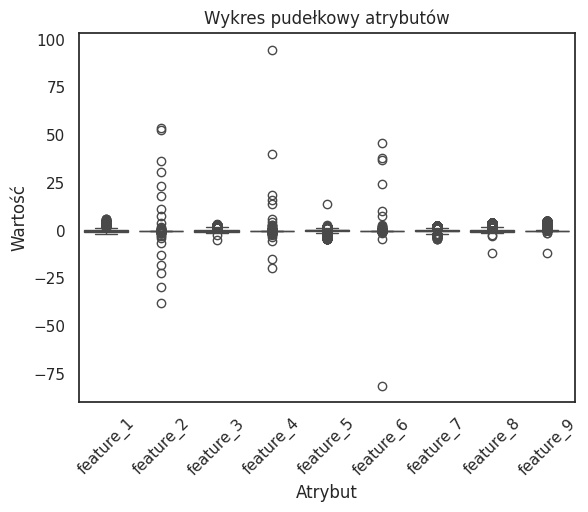

In [ ]:
plotting_functions.plot_feature_dist(shuttle_features)

Jeszcze bardziej niż w przypadku zbioru "thyroid", na zbiorze "shuttle" widzimy że wszystkie atrybuty maja bardzo mocno odstające od więszkości przykłady pod względem wartości atrybutów.

### Wizualizcja 3d głównych składowych zbioru "shuttle"

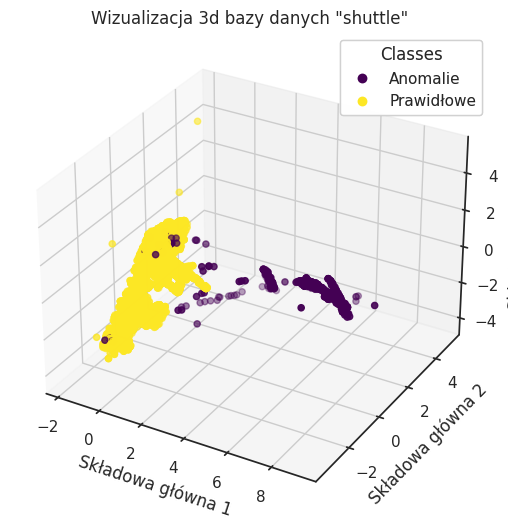

In [ ]:
# 3D PCA thyroid dataset visualization

# remove some extreme values for visualization (this is used insead of crop/zoom)
PCA_shuttle_features = shuttle_features[shuttle_features < 20].dropna()
PCA_shuttle_labels = shuttle_labels.iloc[PCA_shuttle_features.index]

plotting_functions.plot_pca_3d(PCA_shuttle_features, PCA_shuttle_labels, "Wizualizacja 3d bazy danych \"shuttle\"")

Przy rozkładzie na 3 główne składowe, widać że anomaplie znajdują się poza głównym skupiskiem danych.

# Testy dla różnych metryk odległości i liczby sąsiadów

Definicja 3 testowanych miar odległości. Miary które wybraliśmy to miara euklidesowa czyli pierwiastek z różnicy kwadratów po wszystkich wymiarach, odległość manhattan czyli różnica po wszystkich wymiarach oraz odległość minkowski z parametrem p=3 czyli pierwiastek tzeciego stopnia z różnycy podniesionej do trzeciej potęgi.

In [ ]:
@nb.jit(nopython=True)
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

@nb.jit(nopython=True)
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

@nb.jit(nopython=True)
def minkowski_distance_p3(x1, x2, p=3):
    return np.sum(np.abs(x1 - x2)**p)**(1/p)

### Testy dla zbioru "thyroid"

In [ ]:
# test parameters
distances = [euclidean_distance, manhattan_distance, minkowski_distance_p3]
n_neighbors = [1, 5, 10, 50, 500]

In [ ]:
result_df = test_functions.test_loop(thyroid_features, thyroid_labels, n_neighbors, distances, [None])

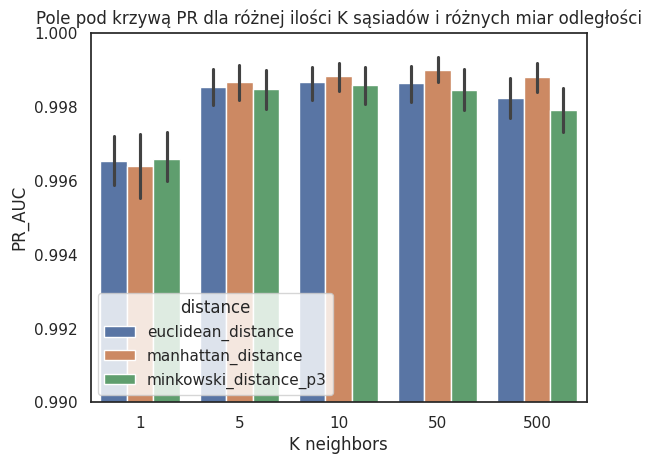

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="K neighbors", y="PR_AUC", hue="distance", ax=ax)
ax.set_ylim(0.99, 1)
plt.title("Pole pod krzywą PR dla różnej ilości K sąsiadów i różnych miar odległości")
plt.show()

Pole pod krzywą PR najpierw rośnie razem ze wzrostem liczby sąsiadów, jednak po przekroczeniu pewnego progu, w tym wypadku około 500 zaczyna spadać. Jak zobaczymy potem przy analizie większego zbioru, optymalna liczba sąsiadów zdaje się być zależna od wielkości zbioru. Można zauważyć, że algorytm najlepiej działa w każdym przypadku orpócz k=1 dla miary odległości manhattan. dla k=1 najlepsza jest odległośc minkowski z parametrem p=3, która to znowu daje najgorsze wyniki w pozostałych przypadkach. Odhylenie standardowe zaznaczone jako czarne paski spada wraz ze wzrostem k ale tendencja ta przestaje być jednoznaczna przy dużych k.

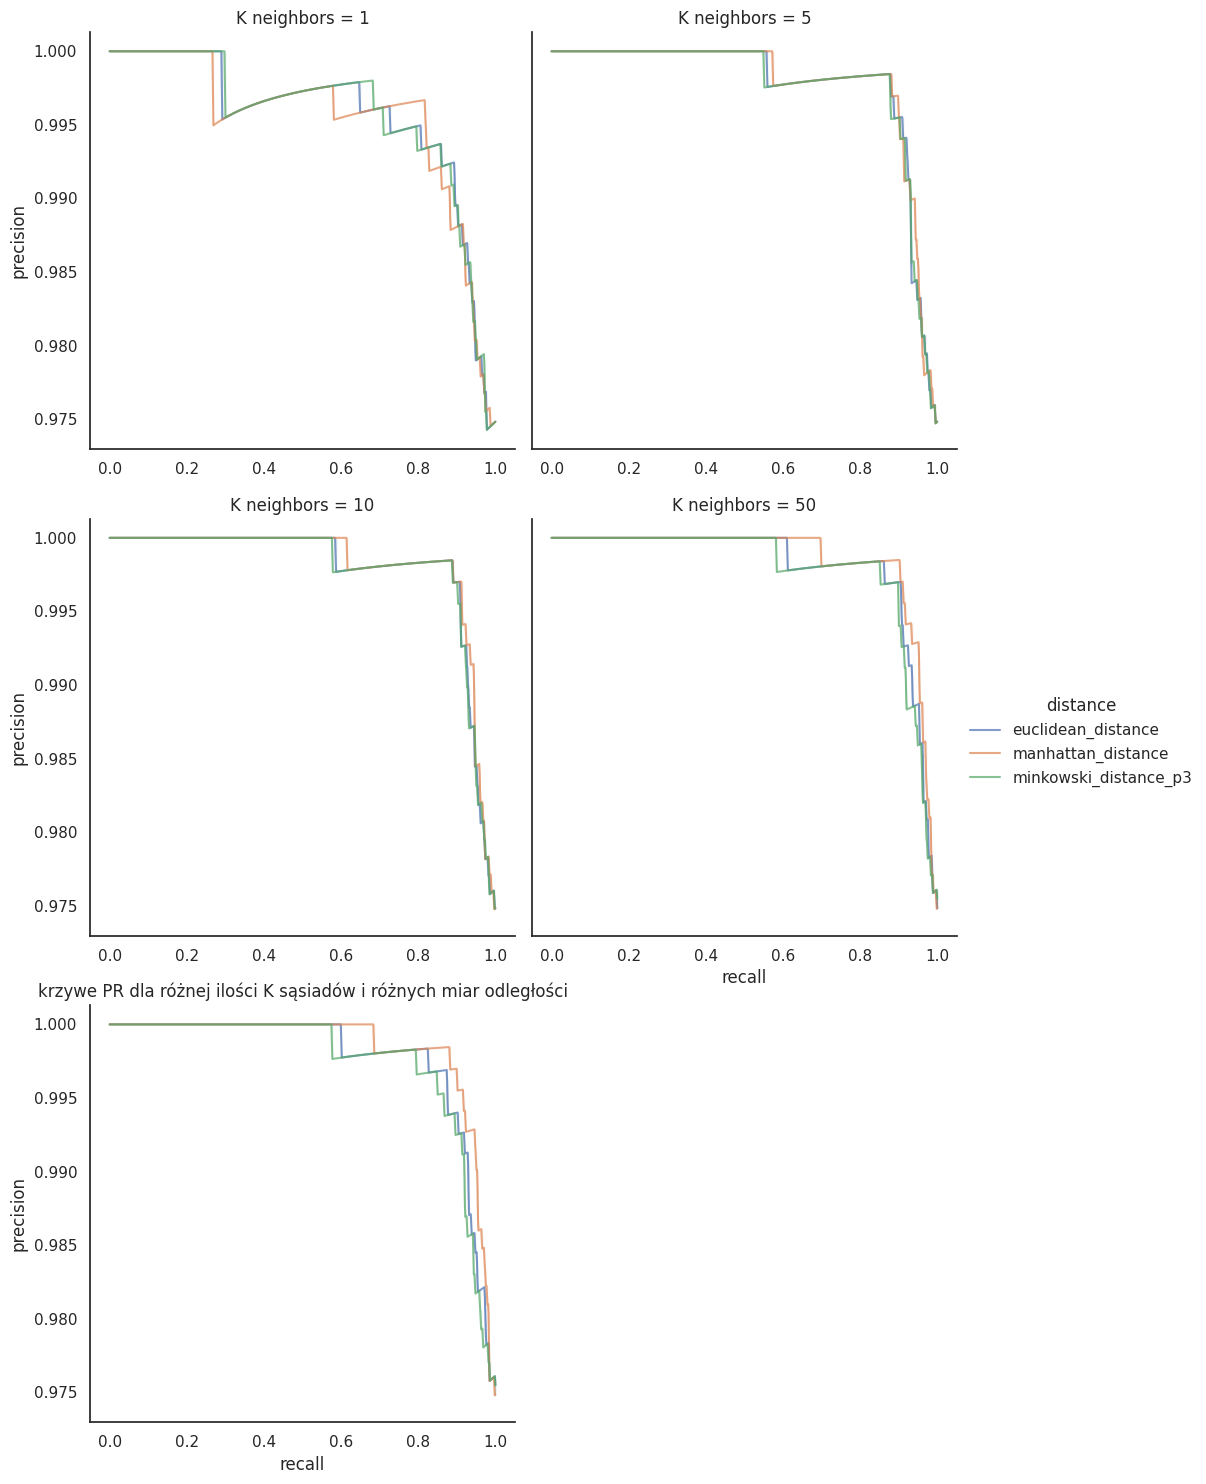

In [ ]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="distance", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)
plt.title("krzywe PR dla różnej ilości K sąsiadów i różnych miar odległości")
plt.show()

Krzywe PR dla różnych miar odległości są bardzo bliskie siebie, ich trajektorie są różne w zależności od liczby sąsiadów. Najlepszy wynik osiągnięto dla liczby sąsiadów równej 50, powyżej której pole pod krzywą PR maleje.

### Testy dla zbioru "shuttle"

In [ ]:
result_df = test_functions.test_loop(shuttle_features, shuttle_labels, n_neighbors, distances, [None])

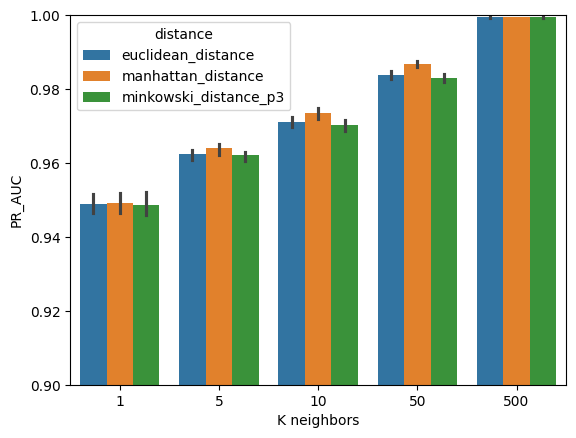

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="K neighbors", y="PR_AUC", hue="distance", ax=ax)
ax.set_ylim(0.9, 1)
plt.show()

Zgodnie z oczekiwaniami dziaanie algorytmu zależy od libczbyu sąsiadów, której optymalna wartość wzrasta wraz z rozmiarem zbioru. Dla Zbioru Shuttle o rozmiarze niemalże ponad 10 000 próbek liczba sąsiadów 500 okazała się dawać najlepsze wyniki, podczas gdy dla zbioru "Thyroid" dawała ona gorsze wyniki niż dla liczby sąsiadów 50.

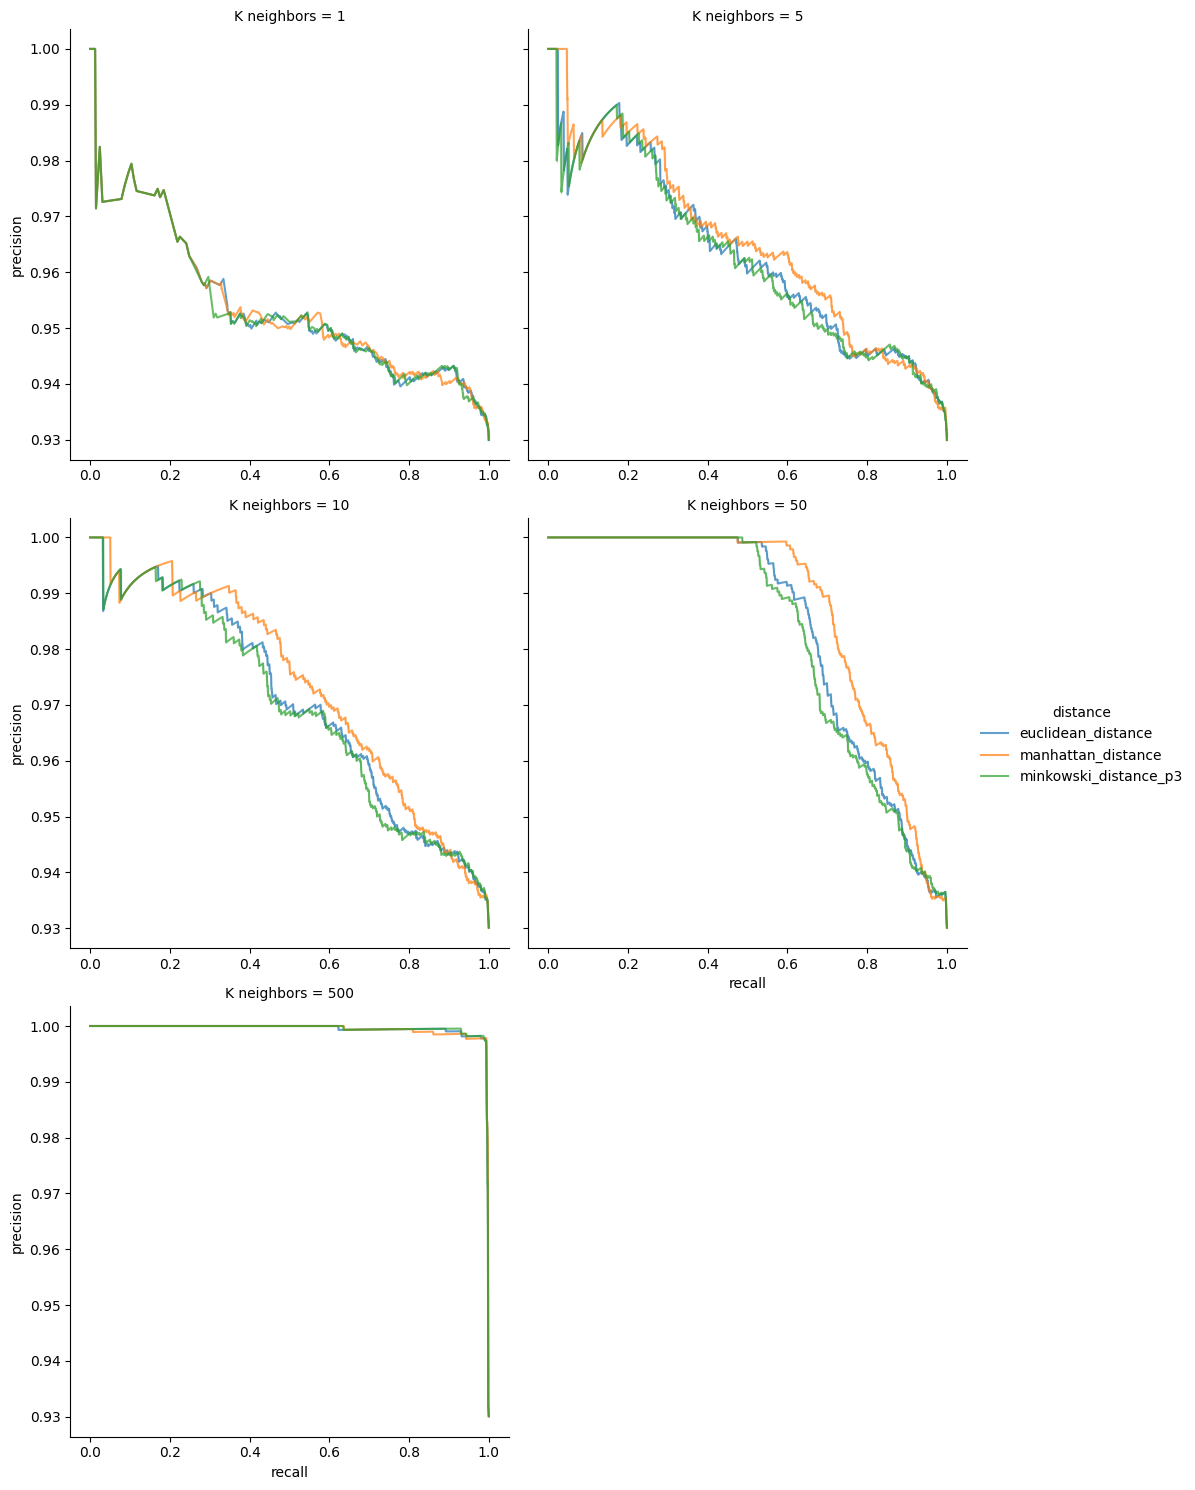

In [ ]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="distance", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

Pole pod krzywą PR ma największą wartość dla liczby sąsiadów 500. Jest to spowodowane wielkością zbioru.

# Testy dla średniej odległości od wszystkich sąsiadów i odległości od k-tego sąsiada

Do testów funkcji oceniających wybrane zostały 3 funkcje. distance_from_nth bierze pod uwagę tylko odległość do n-tego sąsiada. Funkcja distance_avg oblicza średnią odległość do wszystkich puntków w zbiorze uczącym. Ostatnia funkcja czyli density to ekperyment w którym obliczana jest średnia odlegkłość k najbliższych sąsiadów dla każdego z k najbliższych sąsiadów ocenianego przykładu.

In [6]:
def distance_from_nth(distances, X, k):
    kth_nearest_neighbor = np.argsort(distances, axis=1)[:, k-1:k]
    return distances[np.arange(len(X))[:, None], kth_nearest_neighbor]

def distance_avg(distances, X, k):
    return np.mean(distances, axis=1)

def density(distances, X, k, fitted_detector=None):
    nearest_neighbors = np.argsort(distances, axis=1)[:, :k]
    if fitted_detector is None:
        fitted_detector = KNNAnomalyDetector(k=k)
        fitted_detector.fit(nearest_neighbors)
    neighbor_scores = fitted_detector.predict(nearest_neighbors)
    neighbor_scores = nearest_neighbors.reshape((-1, k)) # ensure 2d
    return np.mean(neighbor_scores, axis=1)

### testy dla zboiru "thyroid"

In [7]:
# test parameters
score_funcs = [distance_from_nth, distance_avg, density]
n_neighbors = [1, 5, 10, 50, 500]

In [11]:
result_df = test_functions.test_loop(thyroid_features, thyroid_labels, n_neighbors, [None], score_funcs)

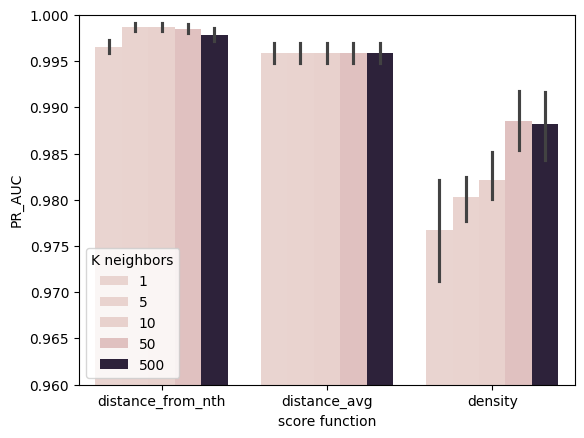

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="score function", y="PR_AUC", hue="K neighbors", ax=ax)
ax.set_ylim(0.96, 1)
plt.show()

W przypadku oceny biorąc pod uwagę k-tego sąsiada, widzimy całkiem dobre działanie dla sąsiada numer 5. Przy uwzględnienieu tylko najbliższego sąsiada jakość predykcji jest słaba, a dla dalszych sąsiadów jakość predykcji również spada. Jest to prawdopodobnie spowodowane tym, że przy wyborze dalszych sąsiadów, łatiwej jest trafić w punkty znajdujące się wśród klasy której przykładów jest więcej.

W przypadku średniej odległości od wszystkich sąsiadów widać że parametr k nie ma na nic wpływu co jest oczywiście oczekiwane. Wyniki też nie jest zaskakujący ponieważ wiemy z poprzednich testów że duże k (tutaj k= liczebność zbioru uczącego) jest gorsza niż dla mniejszych liczb sąsiadów.

Wymyślona przez nas miara density daje gorsze rezultaty od pozostałych 2 funkcji i jej ochylenie standardowe w iteracjach walidacji krzyżowej jest znacznie większe, co może sugerować że nie jest medota oceny na której można polegać.

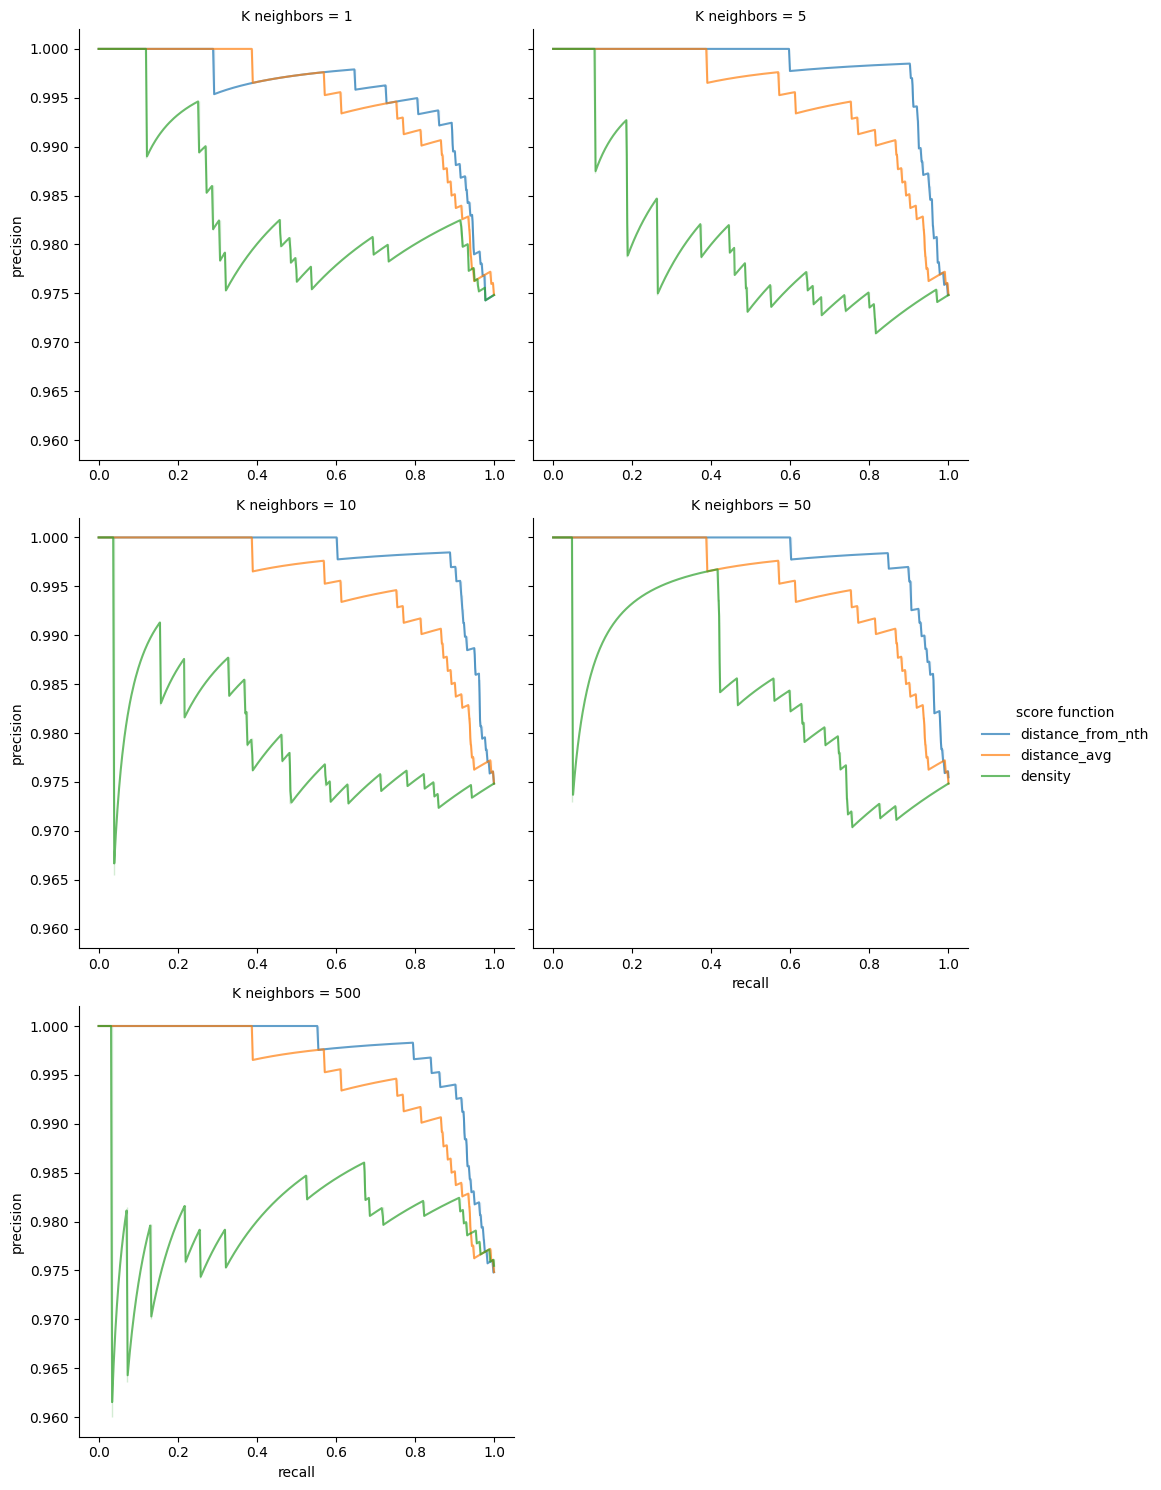

In [ ]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]

pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="score function", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

Na krzywych PR od razu widać dziwne zachowanie metryki density.

### testy dla zbioru shuttle

In [ ]:
result_df = test_functions.test_loop(shuttle_features, shuttle_labels, n_neighbors, [None], score_funcs)

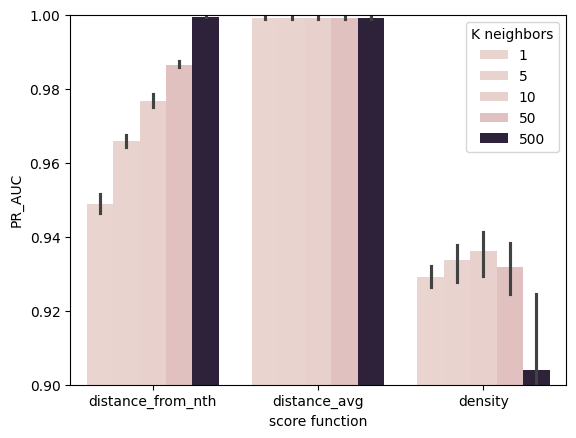

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="score function", y="PR_AUC", hue="K neighbors", ax=ax)
ax.set_ylim(0.90, 1)
plt.show()

Dla zbioru "Shuttle" najlepiej działa mierzenie odległości bazując na średniej odleglości od k sąsiadów. Wyniki dla mierzenia doległości na podstawie odległości od k-tego sąsiada wzrastają wraz z liczbą sąsiadów na badanym zakresie.
Wynik ten jest o tyle ciekawy że obala teze o tym że jakość predykcji zacznie spadać jak wybierzemy wystaarczająco duże k. Na podstawie przeprowadzonego testu nie jesteśmy w stanie jednoznacznie stwierdzić że k=ilości przykładów w zbiorze treningowym jest najlepsze ale na pewdno otrzymany wynik jest bardzo dobry.

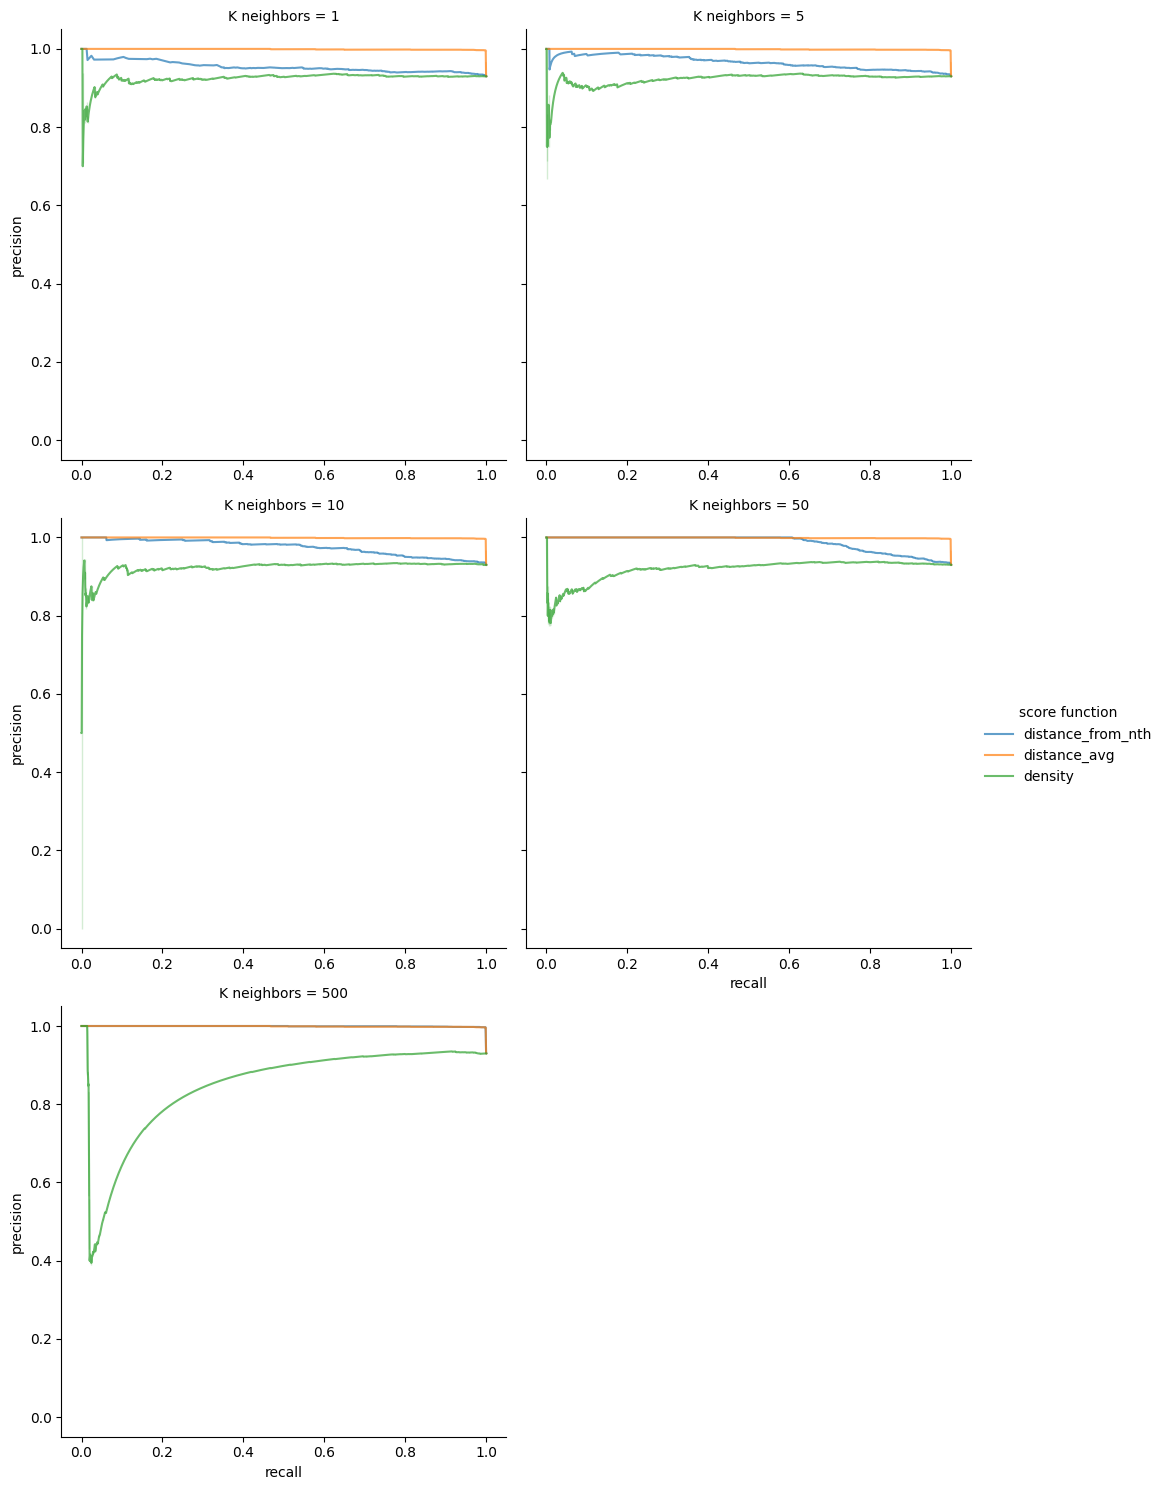

In [ ]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
#pr_df = pr_df[pr_df["K neighbors"] == 10]

pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="score function", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

# Testy dla treningu bez anomalii oraz traningu z anomaliami

Podczas tego testu, przykłady które są anomaliami zostaną usnunięte ze zbioru trenignowego.

Dla zbioru "thyroid"

In [ ]:
filters_inliers = [True, False]
n_neighbors = [5]
thresholds = [80, 95, 100]

In [ ]:
result_df = test_functions.test_loop(thyroid_features, thyroid_labels,
                                     n_neighbors, [None], [None],
                                     thresholds=thresholds,
                                     filter_inliers=filters_inliers)

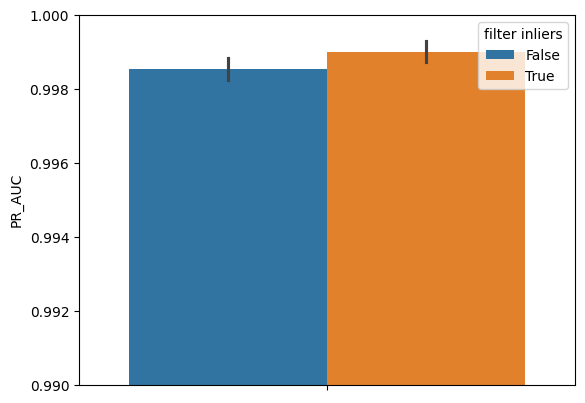

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, y="PR_AUC", hue="filter inliers")
ax.set_ylim(0.99, 1)
plt.show()

Trening na nie-anomaliach daje lepsze wyniki niż treninbg na wszystkich danych.

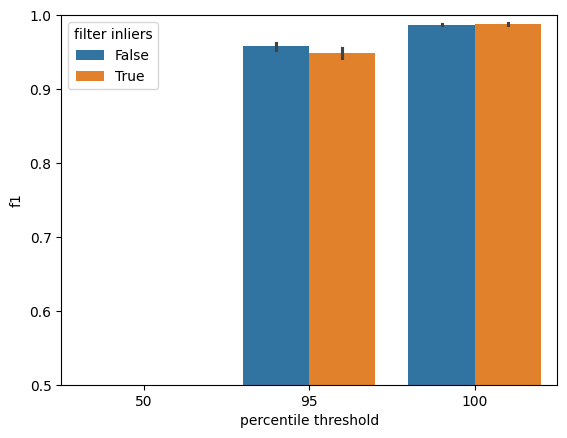

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="percentile threshold", y="f1", hue="filter inliers")
ax.set_ylim(0.5, 1)
plt.show()

Co ciekawe obu przypadkach lepszy wynik daje trenowanie na progu równym 100 centylom. Widać jednak że ustalenie progu bliżej ilości procentowej ilości przykładów klasy większościowej da lepsze wyniki przy trenowaniu na zbiorze który zawiera anomalie, więc jeśli nie mamy dostępu do "czystego" zbioru, a możemy oszacować oczekiwany stostusek anomalii do klasy większościowej, jest to sposób który może polepszyć jakość predykcji.

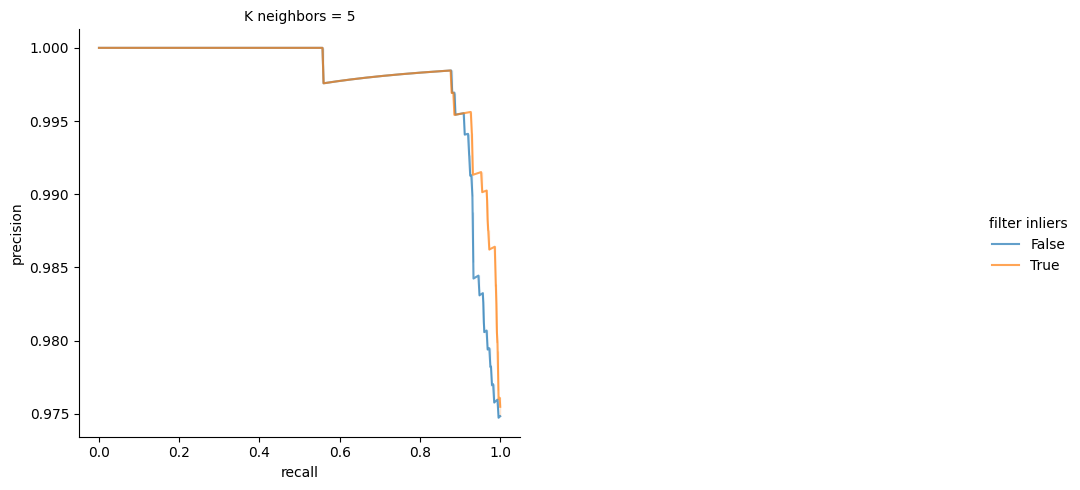

In [ ]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df[pr_df["percentile threshold"] == 100]
pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="filter inliers", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

Większą powierzchnię pod krzywą PR uzyskano dla modelu trenowanego na nie-anomaliach.

## Dla zbioru "shuttle"

In [ ]:
result_df = test_functions.test_loop(shuttle_features, shuttle_labels,
                                     n_neighbors, [None], [None],
                                     thresholds=thresholds,
                                     filter_inliers=filters_inliers)

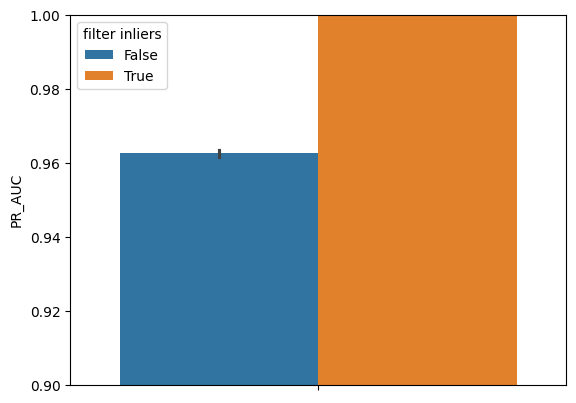

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, y="PR_AUC", hue="filter inliers")
ax.set_ylim(0.90, 1)
plt.show()

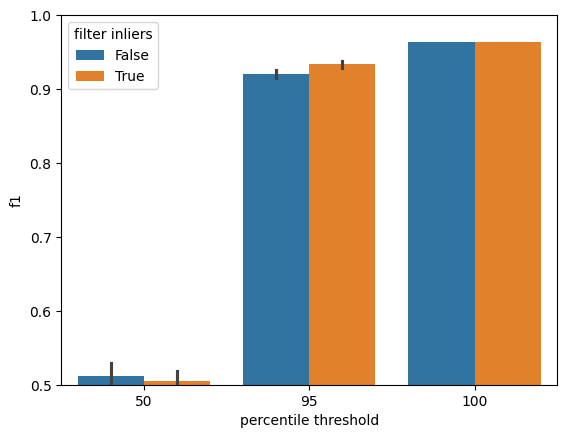

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="percentile threshold", y="f1", hue="filter inliers")
ax.set_ylim(0.5, 1)
plt.show()

Dla zbioru shuttle widzimy że lepszą jakość predykcji uzyskujemy dla zbiou uczącego bez anomalii nawet jeśli próg jest ustawiony blisko faktycznej ilości anomalii w zbiorze danych.

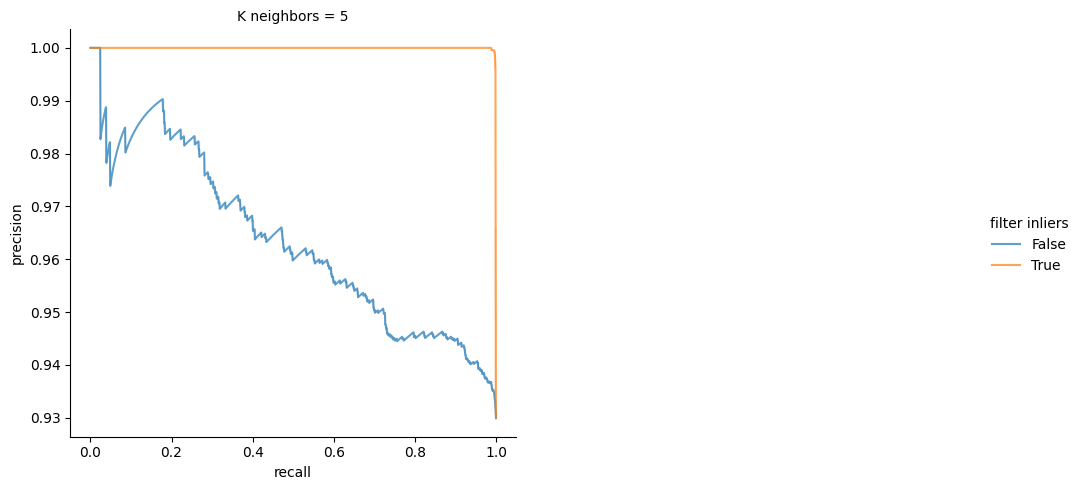

In [ ]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df[pr_df["percentile threshold"] == 100]
pr_df = pr_df.explode(['recall', 'precision'])



sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="filter inliers", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.7
)

Dla 5-ciu sąsiadów znacznie lepsze wyniki osiągnięto dla modelu trenowanego na nie-anomaliach.

## Porównanie do implementacji z biblioteki sklearn i innych detektorów anomalii

### Porownanie do bibliotecznego KNN

In [ ]:
k_list = [1, 5, 10, 50]
X = np.array(thyroid_features)
y = np.array(thyroid_labels)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_arr = []
precision_arr = []
recall_arr = []
PR_AUC_arr = []
k_neighbors_arr = []
cv_arr = []
detector_arr = []


for k in k_list:
    detector1 = KNNAnomalyDetector(k=k)
    detector2 = KNN(contamination=0.05, n_neighbors=k, method='mean', n_jobs=-1)

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        detector1.fit(X_train)
        detector2.fit(X_train)
        predictions1 = detector1.predict(X_test)
        predictions2 = detector2.predict(X_test)
        predictions2 = predictions2 * -2 + 1

        scores = detector1.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, -scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions1, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append("Our implementation")

        scores = detector2.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, -scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions2, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append("PYOD implementation")

result_df = pd.DataFrame({"f1":f1_arr, "precision":precision_arr, "recall":recall_arr,
                            "PR_AUC":PR_AUC_arr,
                            "K neighbors":k_neighbors_arr, "CV":cv_arr,
                            "detector": detector_arr})

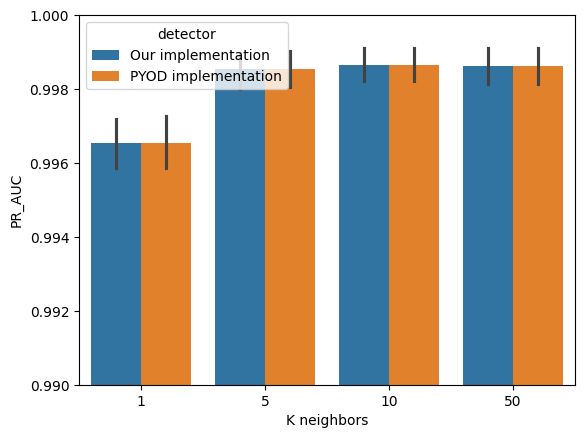

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="K neighbors", y="PR_AUC", hue="detector")
ax.set_ylim(0.99, 1)
plt.show()

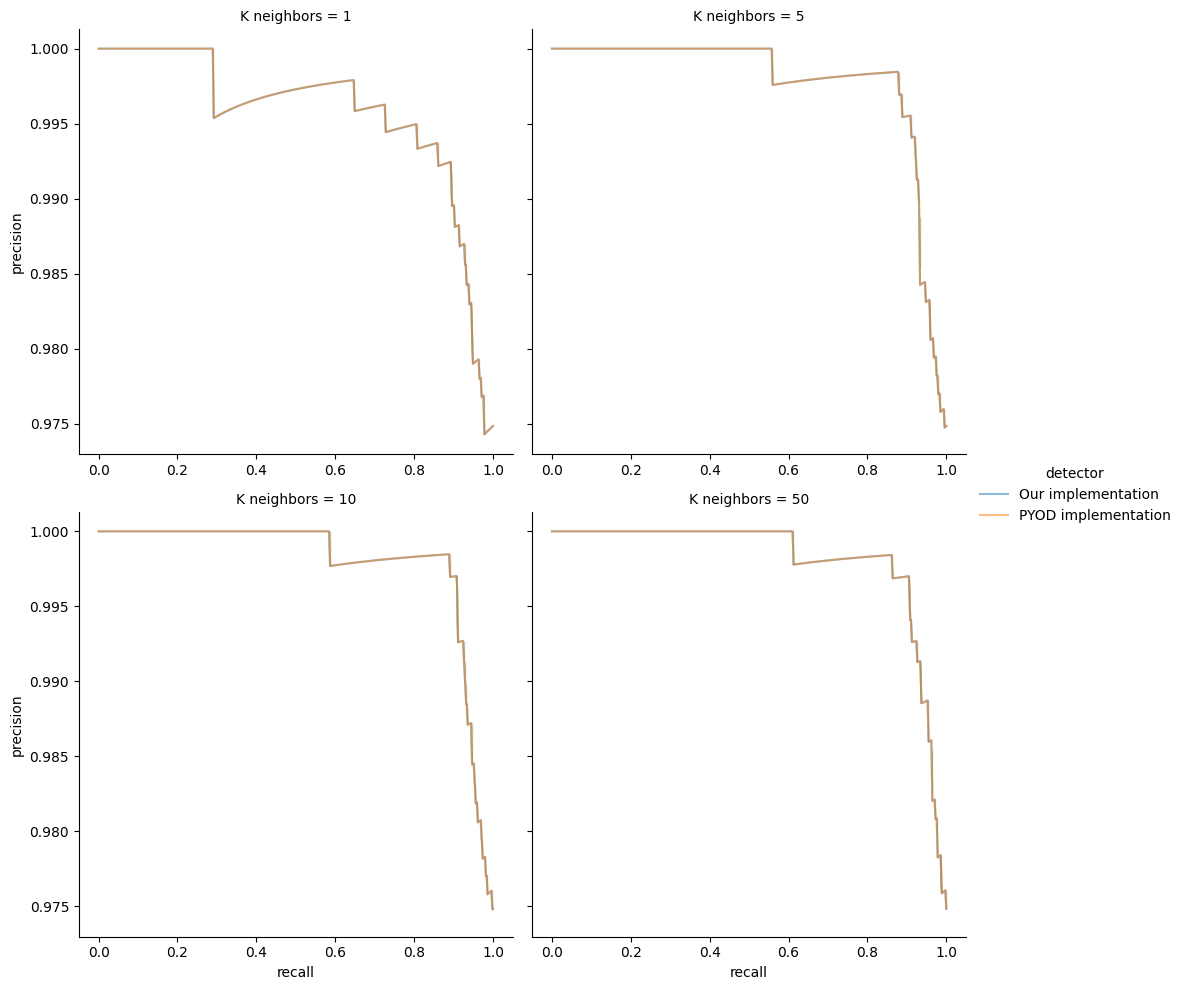

In [ ]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="detector", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.5
)

W porównaniu do implementacji tego samego algorytmu z biblioteki PYOD, rezultaty są identyczne.

## To samo dla shuttle

In [ ]:
X = np.array(shuttle_features)
y = np.array(shuttle_labels)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_arr = []
precision_arr = []
recall_arr = []
PR_AUC_arr = []
k_neighbors_arr = []
cv_arr = []
detector_arr = []


for k in k_list:
    detector1 = KNNAnomalyDetector(k=k)
    detector2 = KNN(contamination=0.05, n_neighbors=k, method='mean', n_jobs=-1)

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        detector1.fit(X_train)
        detector2.fit(X_train)
        predictions1 = detector1.predict(X_test)
        predictions2 = detector2.predict(X_test)
        predictions2 = predictions2 * -2 + 1

        scores = detector1.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, -scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions1, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append("Our implementation")

        scores = detector2.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, -scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions2, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append("PYOD implementation")

result_df = pd.DataFrame({"f1":f1_arr, "precision":precision_arr, "recall":recall_arr,
                            "PR_AUC":PR_AUC_arr,
                            "K neighbors":k_neighbors_arr, "CV":cv_arr,
                            "detector": detector_arr})

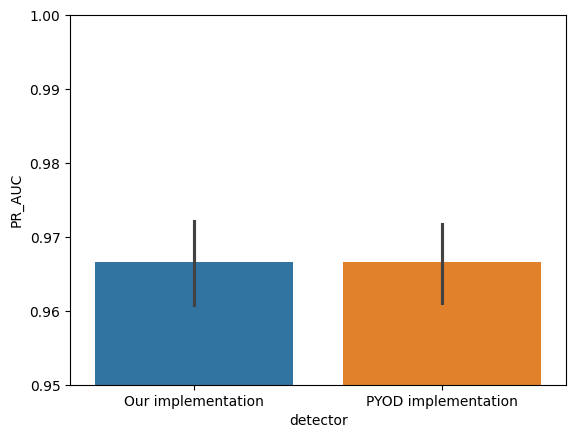

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="detector", y="PR_AUC", hue="detector")
ax.set_ylim(0.95, 1)
plt.show()

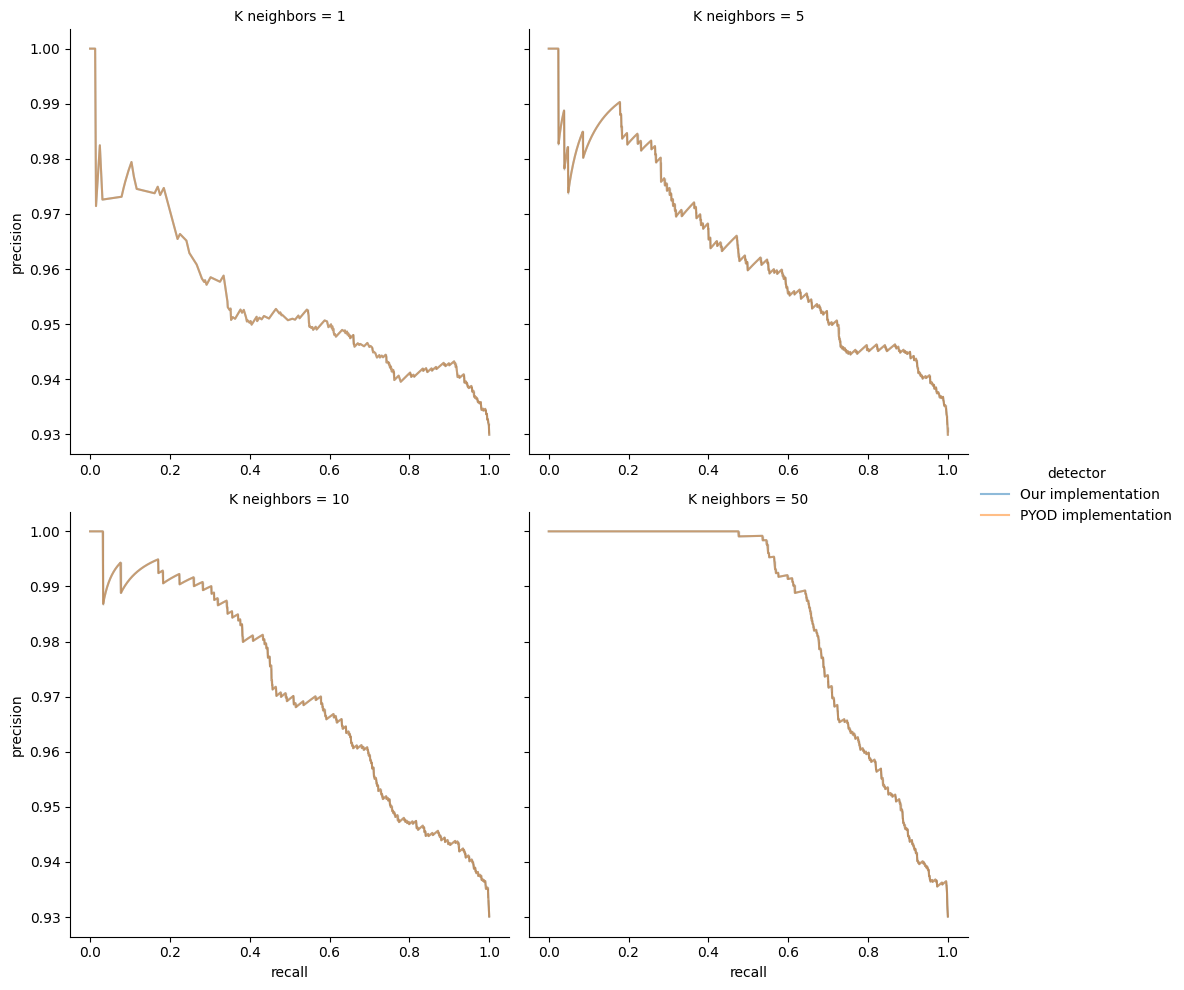

In [ ]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="detector", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.5
)

Na zbiorze "shuttle" pokrycie też jest idealne.

### porownanie do innych algorytmow

Dla zbioru "thyroid"

In [ ]:
X = np.array(thyroid_features)
y = np.array(thyroid_labels)

In [ ]:
detectors = [KNNAnomalyDetector(k=50), sklearn.neighbors.LocalOutlierFactor(n_neighbors=50, novelty=True), sklearn.ensemble.IsolationForest(), sklearn.svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)]
detector_names = ["LOF", "Isolation Forest", "SVM rbf", "Our KNN"]

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_arr = []
precision_arr = []
recall_arr = []
PR_AUC_arr = []
k_neighbors_arr = []
cv_arr = []
detector_arr = []

for n, detector in enumerate(detectors):
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        detector.fit(X_train)
        predictions = detector.predict(X_test)

        scores = detector.decision_function(X_test)
        if n == 0:
            precision, recall, _ = precision_recall_curve(y_test, -scores)
        else:
            precision, recall, _ = precision_recall_curve(y_test, scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append(detector_names[n])

result_df = pd.DataFrame({"f1":f1_arr, "precision":precision_arr, "recall":recall_arr,
                            "PR_AUC":PR_AUC_arr,
                            "K neighbors":k_neighbors_arr, "CV":cv_arr,
                            "detector": detector_arr})

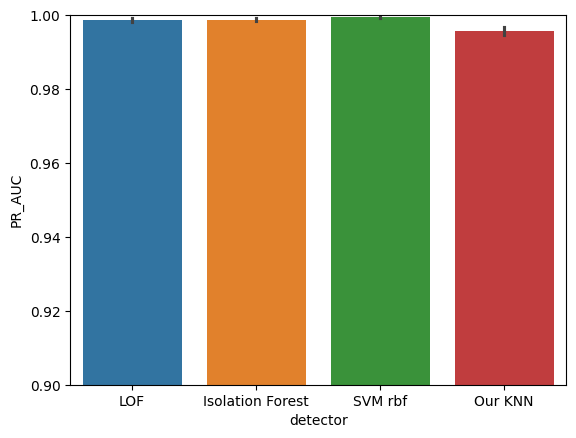

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="detector", y="PR_AUC", hue="detector")
ax.set_ylim(0.99, 1)
plt.show()

Nasza implementacja algorytmu przy liczbie najbliższych sąsiadów ustawionej na 50 daje nieco gorsze rezultaty od innych rozważanych algorytmów, nie jest to jednak ogromna różnica. Wszystkie wyniki przebijają wartość PR AUC=0.99. Algorytm SVM z nieliniowym jądrem rbf jest najlepszy wsród testowanych.

<Axes: xlabel='recall', ylabel='precision'>

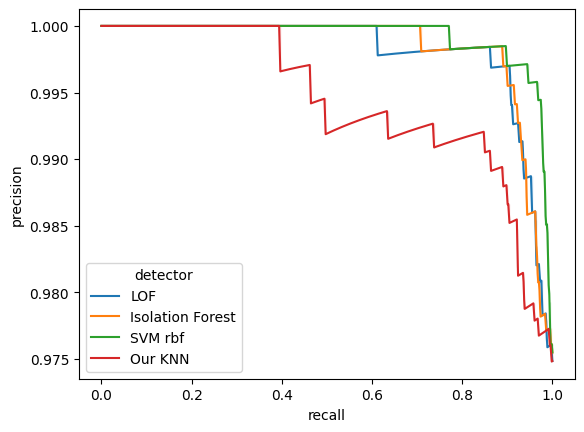

In [ ]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df.explode(['recall', 'precision'])

sns.lineplot(data=pr_df, x="recall", y="precision", hue="detector")

## Dla zbioru "shuttle"

In [ ]:
X = np.array(shuttle_features)
y = np.array(shuttle_labels)

In [ ]:
detectors = [KNNAnomalyDetector(k=50), sklearn.neighbors.LocalOutlierFactor(n_neighbors=50, novelty=True), sklearn.ensemble.IsolationForest(), sklearn.svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)]
detector_names = ["LOF", "Isolation Forest", "SVM rbf", "Our KNN"]

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_arr = []
precision_arr = []
recall_arr = []
PR_AUC_arr = []
k_neighbors_arr = []
cv_arr = []
detector_arr = []

for n, detector in enumerate(detectors):
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        detector.fit(X_train)
        predictions = detector.predict(X_test)

        scores = detector.decision_function(X_test)
        if n == 0:
            precision, recall, _ = precision_recall_curve(y_test, -scores)
        else:
            precision, recall, _ = precision_recall_curve(y_test, scores)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, predictions, average='binary')

        f1_arr.append(f1)
        precision_arr.append(precision)
        recall_arr.append(recall)
        PR_AUC_arr.append(pr_auc)
        k_neighbors_arr.append(k)
        cv_arr.append(i)
        detector_arr.append(detector_names[n])

result_df = pd.DataFrame({"f1":f1_arr, "precision":precision_arr, "recall":recall_arr,
                            "PR_AUC":PR_AUC_arr,
                            "K neighbors":k_neighbors_arr, "CV":cv_arr,
                            "detector": detector_arr})

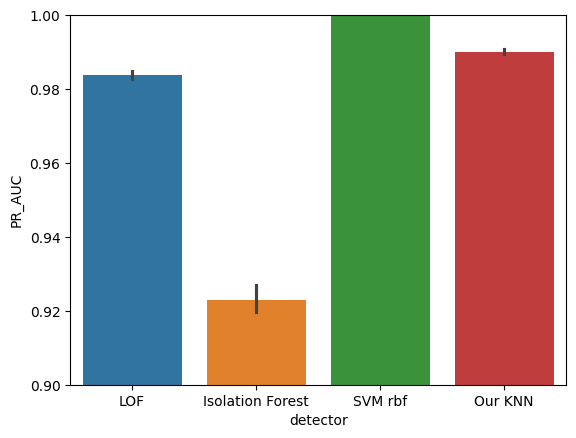

In [ ]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="detector", y="PR_AUC", hue="detector")
ax.set_ylim(0.9, 1)
plt.show()

Co ciekawe na zbiorze "shuttle" algorytm isolation forest sprawdza się znacznie gorzej od pozostałych. SVM dalej prowadzi a na drugim miejscu znajduje się KNN z wynikami lepszymi nawet od algorytmu LOF. Co ciekawe algorytm KNN z funckją oceny obliczającą średnią odległość do wszystkich sąsiadów, dawał wyniki porównywalne do SVM.

<Axes: xlabel='recall', ylabel='precision'>

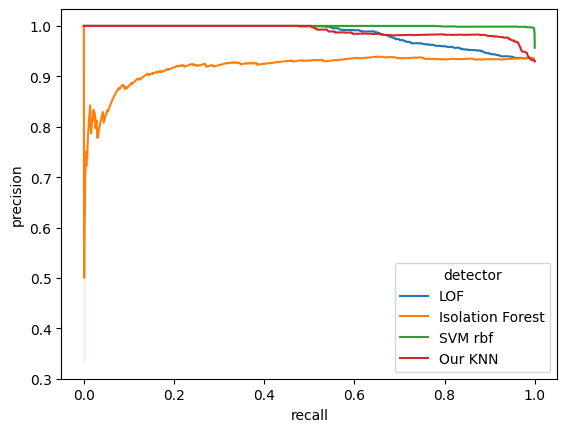

In [ ]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df.explode(['recall', 'precision'])

sns.lineplot(data=pr_df, x="recall", y="precision", hue="detector")

## Wnioski

Nienadzorowany algorytm k najbliższych sąsiadów jest wzlgędnie nie skąplikowanym koncepcyjnie algorytmem wykrywania anomalii. Przy dobraniu odpowiednich parametrów algorytm ten daje dobre wyniki, porównywalne z dużo bardziej złożonymi algorytmami.

W przypadku dobierania liczby sąsiadów, ilości porównywalne z ilością anomalii w zbiorze treningowym zdają się działać dobrze. Reszta parametrów zdaje się być zależna od zbioru danych z którym mamy do czynienia. Dla zbioru shuttle na przykład, funkcja oceny biorąca pod uwagę odległość od całego zbioru uczącego dawała bardzo dobre wyniki, porównywalne nawet z algorytmem SVM i nieliniowym jądrem rbf który według opinii z internetu daje zazwyczaj najlepsze wyniki.

## Dodatek: LOF

In [12]:
def distance_from_nth(distances, X, k):
    kth_nearest_neighbor = np.argsort(distances, axis=1)[:, k-1:k]
    return distances[np.arange(len(X))[:, None], kth_nearest_neighbor]

def distance_avg(distances, X, k):
    return np.mean(distances, axis=1)

def density(distances, X, k, fitted_detector=None):
    nearest_neighbors = np.argsort(distances, axis=1)[:, :k]
    if fitted_detector is None:
        fitted_detector = KNNAnomalyDetector(k=k)
        fitted_detector.fit(nearest_neighbors)
    neighbor_scores = fitted_detector.predict(nearest_neighbors)
    neighbor_scores = nearest_neighbors.reshape((-1, k)) # ensure 2d
    return np.mean(neighbor_scores, axis=1)

In [13]:
# test parameters
score_funcs = [distance_from_nth, distance_avg, density, "LOF"]
n_neighbors = [5, 10, 50]
result_df = test_functions.test_loop(thyroid_features, thyroid_labels, n_neighbors, [None], score_funcs)

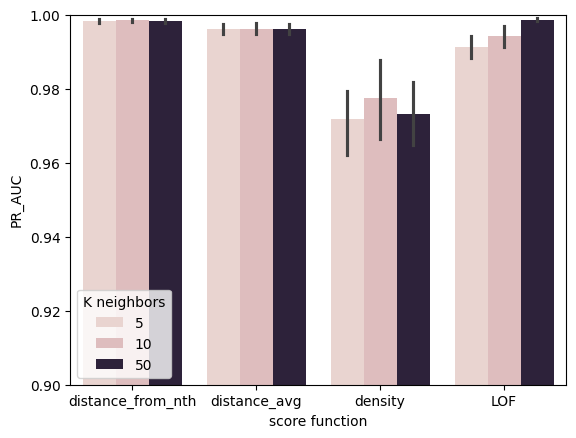

In [14]:
fig, ax = plt.subplots()
sns.barplot(result_df, x="score function", y="PR_AUC", hue="K neighbors", ax=ax)
ax.set_ylim(0.90, 1)
plt.show()

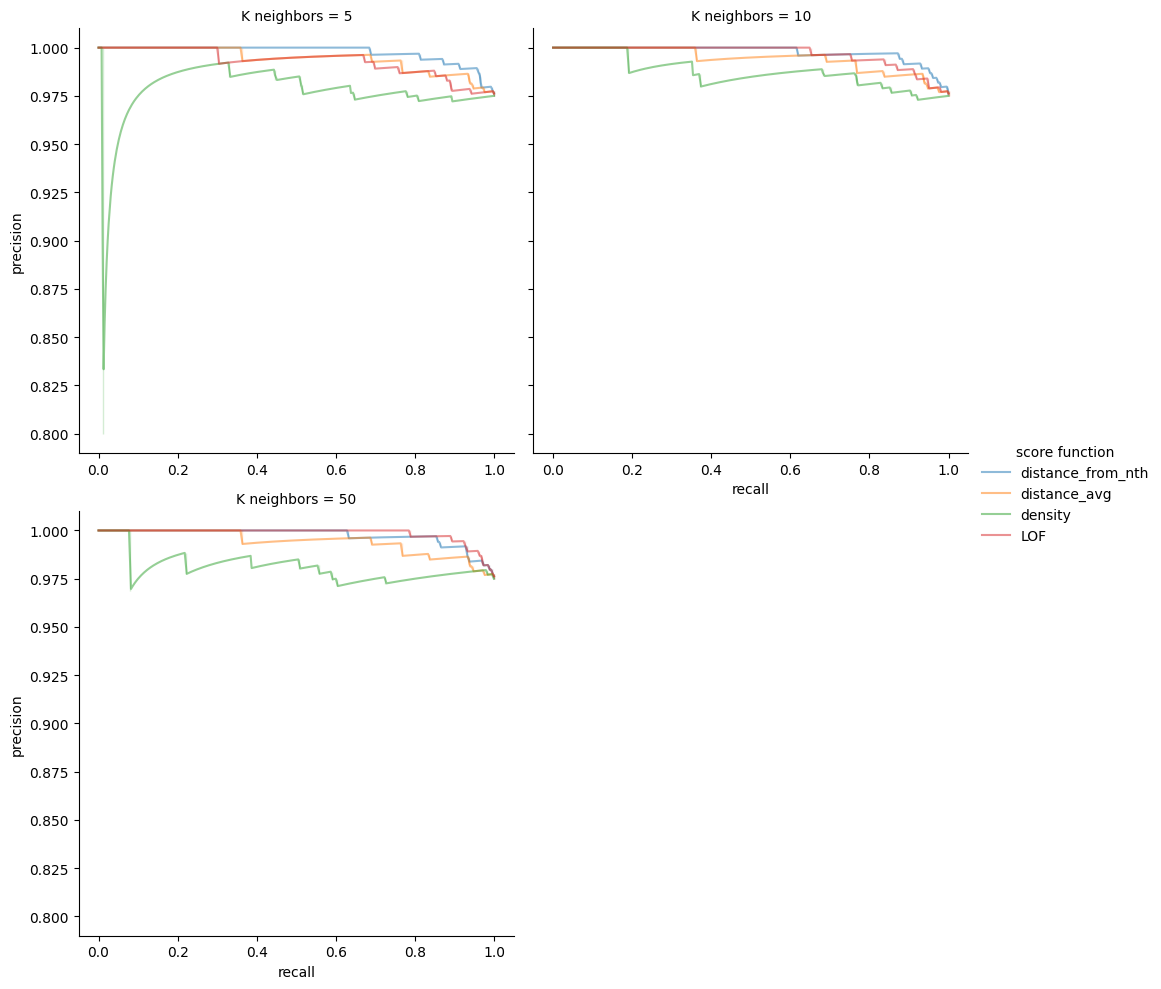

In [15]:
#plot PR curves
pr_df = result_df[result_df["CV"] == 1]
pr_df = pr_df.explode(['recall', 'precision'])

sns.relplot(
    data=pr_df,
    x="recall", y="precision",
    hue="score function", col="K neighbors",
    kind="line",
    facet_kws=dict(sharex=False),
    col_wrap=2,
    alpha=0.5
)